In [1]:
print("No configuration needed")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import matplotlib.pyplot as plt

#DESIGN PARAMETERS FOR NEURAL NETWORK
NR_LSTM_UNITS = 2
IMAGE_INPUT_SIZE = 228
IMAGE_AFTER_CONV_SIZE = 5
#for 3x3 kernels, n=num_layers: len_in = 2^n*len_out + sum[i=1..n](2^i)
#CONV_LAYER_LENGTH = 5

LSTM_IO_SIZE = IMAGE_AFTER_CONV_SIZE*IMAGE_AFTER_CONV_SIZE

RGB_CHANNELS = 3
TIMESTEPS = 10
BATCH_SIZE = 1 #until now just batch_size = 1
NR_EPOCHS = 400
LEARNING_RATE = 0.1
loss_array = []

#USE RANDOM IMAGES TO SET UP WORKING EXAMPLE
class TEST_CNN_LSTM(nn.Module):
    def __init__(self):
        super(TEST_CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3) #input 388x388
        self.pool1 = nn.MaxPool2d(2,2) #input 48x48 output 24x24
        self.conv2 = nn.Conv2d(6,16,3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16,6,3)
        self.pool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(6,3,3)
        self.pool4 = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(3,1,3)
        self.pool5 = nn.MaxPool2d(2,2) #output 5x5
        self.lstm = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_IO_SIZE,
                            NR_LSTM_UNITS)
        self.fc1 = nn.Linear(LSTM_IO_SIZE,120)
        self.fc2 = nn.Linear(120,20)
        self.fc3 = nn.Linear(20,3)
        
        #initialize hidden states of LSTM
        self._hidden = (torch.randn(NR_LSTM_UNITS, BATCH_SIZE, LSTM_IO_SIZE), 
                        torch.randn(NR_LSTM_UNITS, BATCH_SIZE, LSTM_IO_SIZE))
        #print("Hidden:", _hidden)
        
    def forward(self,x):
        #print("Input:", x.size())
        x = x.float() #necessary for some reason
        x_arr = torch.zeros(TIMESTEPS,IMAGE_AFTER_CONV_SIZE,IMAGE_AFTER_CONV_SIZE)
        #print("X arr size", x_arr.size())
        for i in range(TIMESTEPS):#parallel convolutions which are later concatenated for LSTM
            x_tmp_c1 = self.pool1(F.relu(self.conv1(x[i].unsqueeze(0))))
            x_tmp_c2 = self.pool2(F.relu(self.conv2(x_tmp_c1)))
            x_tmp_c3 = self.pool3(F.relu(self.conv3(x_tmp_c2)))
            x_tmp_c4 = self.pool4(F.relu(self.conv4(x_tmp_c3)))
            x_tmp_c5 = self.pool5(F.relu(self.conv5(x_tmp_c4)))
            x_arr[i] = torch.squeeze(x_tmp_c5)
        #
        x, _hidden = self.lstm(x_arr.view(TIMESTEPS,BATCH_SIZE,-1), self._hidden)
        x = x.view(-1,LSTM_IO_SIZE)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
print("Class defined")

std_dev = 0.1
#rand_arr = np.random.rand(TIMESTEPS,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)
arr_1 = np.full((1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE),-0.5)
arr_2 = np.full((1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE),0.0)
arr_3 = np.full((1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE),0.5)
arr_full = np.concatenate(
    (arr_1 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_2 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_3 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_1 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_2 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_3 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_1 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_2 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_3 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)),
     arr_1 + np.random.normal(0,std_dev,(1,RGB_CHANNELS,IMAGE_INPUT_SIZE,IMAGE_INPUT_SIZE)))
)
print("Shape", np.shape(arr_full))
# print(arr_full[0])
test_images = torch.from_numpy(arr_full)
test_labels = torch.tensor([0,1,2,0,1,2,0,1,2,0]) #DIFFICULT
# test_labels = torch.tensor([0,0,0,1,1,1,2,2,2,2])#EASY

#TRAINING
test_net = TEST_CNN_LSTM()
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = optim.SGD(test_net.parameters(), lr=LEARNING_RATE, momentum=0.9)



No configuration needed
Class defined
Shape (10, 3, 228, 228)


In [2]:
print('Start training...')
for epoch in range(NR_EPOCHS): 
    print("Epoch:", epoch)
    running_loss = 0.0
    #for i in range(TIMESTEP):
    inputs = test_images
    labels = test_labels

    optimizer.zero_grad() 
    outputs = test_net(inputs)
#     print("Out:", len(outputs),outputs.size(),  outputs)
#     print("Labels:", len(labels),labels.size() , labels)
    loss = criterion(outputs, labels)
    loss.backward() 
    
    optimizer.step()

    running_loss += loss.item()
    print("Loss:", running_loss)
    loss_array.append(running_loss)
print('...Training finished')


Start training...
Epoch: 0
Loss: 1.0976779460906982
Epoch: 1
Loss: 1.0966031551361084
Epoch: 2
Loss: 1.0947812795639038
Epoch: 3
Loss: 1.0924937725067139
Epoch: 4
Loss: 1.0901482105255127
Epoch: 5
Loss: 1.0880153179168701
Epoch: 6
Loss: 1.0863227844238281
Epoch: 7
Loss: 1.0850980281829834
Epoch: 8
Loss: 1.0843178033828735
Epoch: 9
Loss: 1.0838254690170288
Epoch: 10
Loss: 1.0834438800811768
Epoch: 11
Loss: 1.0829765796661377
Epoch: 12
Loss: 1.0823498964309692
Epoch: 13
Loss: 1.081400752067566
Epoch: 14
Loss: 1.0801050662994385
Epoch: 15
Loss: 1.078506588935852
Epoch: 16
Loss: 1.0766942501068115
Epoch: 17
Loss: 1.0747320652008057
Epoch: 18
Loss: 1.0727479457855225
Epoch: 19
Loss: 1.070787787437439
Epoch: 20
Loss: 1.068805456161499
Epoch: 21
Loss: 1.066819429397583
Epoch: 22
Loss: 1.0647982358932495
Epoch: 23
Loss: 1.0626342296600342
Epoch: 24
Loss: 1.0602073669433594
Epoch: 25
Loss: 1.0575836896896362
Epoch: 26
Loss: 1.0547447204589844
Epoch: 27
Loss: 1.051781415939331
Epoch: 28
Loss: 1.

KeyboardInterrupt: 

In [ ]:
NR_EPOCHS = 100
print("done")

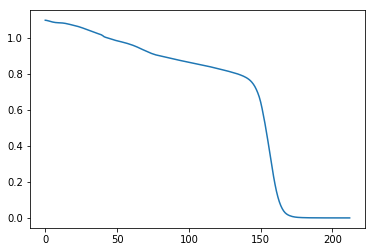

In [3]:
plt.plot(loss_array)